In [1]:
%reset

# ***Importing Libraries***

In [2]:
import torch 
import pickle
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from random import randint
import numpy.random as npr
from matplotlib import pyplot as plt, patches
import torch.optim as optim
from torch.utils.data import random_split
from numpy import linalg as LA

from cr3bp import EarthMoon
import cr3bp
import scipy

# ***Dynamics Function***

In [3]:
# function to output the time derivative state space dynamics of the satellite in the CR3BP
def CR3BPdyn(t,x,mu):
    
    ax = x[0]+2*x[4]-((1-mu)*(x[0]+mu))/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*(x[0]-(1-mu)))/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in x-dir based on CR3BP
    ay = x[1]-2*x[3]-((1-mu)*x[1])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[1])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in y-dir based on CR3BP
    az = -((1-mu)*x[2])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[2])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in z-dir based on CR3BP

    fdyn = np.array([x[3], x[4], x[5], ax, ay, az])
    return fdyn

# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, mu, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk, mu, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), mu, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), mu, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt), mu, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

In [5]:
# CR3BP parameters
G = 6.67408E-20  # Univ. Gravitational Constant [km3 kg-1 s-2]
mEarth = 5.97219E+24  # Mass of the Earth [kg]
mMoon = 7.34767E+22  # Mass of the Moon [kg]
a = 3.844E+5  # Semi-major axis of Earth and Moon [km]
m1 = mEarth
m2 = mMoon
Mstar = m1+m2  # ND Mass Parameter
Lstar = a  # ND Length Parameter
Tstar = (Lstar**3/(G*Mstar))**(1/2)  # ND Time Parameter
mu = m2/Mstar

number_of_initial_conditions = 500
dp = 2000
tf = 90*86400/Tstar
# tf = ((4*3.14159**2)/mu)**0.5
nx = 6 # state space representation of the model has 4 states
m = 3 # number of control states
predict_time = 25

# creating empty vectors to store data
data_x = torch.zeros((0,dp-predict_time+1, nx))
data_y = torch.zeros((0,dp-predict_time+1, nx))
data_y2 = torch.zeros((0,dp-predict_time+1, nx))

# looping through all the initial conditions
for num in range(number_of_initial_conditions):

    EM = cr3bp.EarthMoon
    eoms = cr3bp.EOMConstructor(EM.mu)
    randomiser = 1 + num/10000
    IC = [randomiser*EM.L1 + 1/EM.l, 0, 0, 0, 0, 0]
    IC[3:5] = cr3bp.initial_velocity(IC[:2], EM.L1, EM.mu)
    x0_CR3BP = IC
    time = np.linspace(0, int(tf), dp)
    dt = tf/dp
    xk = x0_CR3BP
    sol = np.empty([6,])
    X = np.empty([nx,])
    Y = np.empty([nx,])

    for t in time:
        X = np.vstack((X, xk))
        xk = rk4(CR3BPdyn, t, xk, mu, dt) # RK4 approximation of solution
        Y = np.vstack((Y, xk))

    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)

    newx = X[1:-(predict_time-1),:]
    newy = Y[predict_time:,:]
    newy2 = Y[1:-(predict_time-1),:]

    # storing in one large data array
    data_x = torch.vstack([data_x, newx[None,:]])  
    data_y = torch.vstack([data_y, newy[None,:]])
    data_y2 = torch.vstack([data_y2, newy2[None,:]])

dp = dp - (predict_time-1)
with open('CR3BP_variables_data.pkl', 'wb') as f:
    pickle.dump([dp,tf,nx,m,predict_time], f)

torch.save(data_x, "X_Data.pt")
torch.save(data_y, "Y_Data.pt")
torch.save(data_y2, "Y2_Data.pt")

In [6]:
solution = scipy.integrate.solve_ivp(cr3bp.EOMConstructor(mu), [0, 90*86400/EM.seconds], IC, atol=0.000001/EM.l, rtol=2.3e-14)
states = solution.y

In [8]:
index = 0

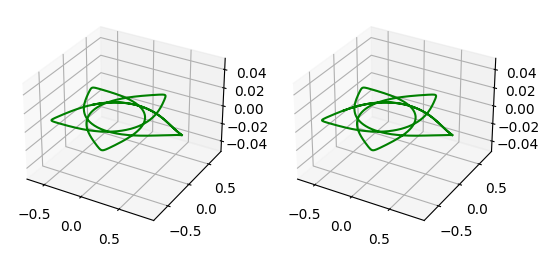

In [10]:
X = data_x.detach().numpy()
# X = EM.conversion_vector*X

X_Sat = X[index,:,0]
Y_Sat = X[index,:,1]
Z_Sat = X[index,:,2]

m1_loc = [-mu, 0, 0]
m2_loc = [(1-mu), 0, 0]

# Rotating Frame Plot
fig = plt.figure()
ax = fig.add_subplot(1,2,1, projection='3d')

# Plotting Rotating Frame Positions
ax.plot3D(X_Sat, Y_Sat, Z_Sat, c='green')

ax = fig.add_subplot(1,2,2, projection='3d')

ax.plot3D(states[0,:], states[1,:], states[2,:], c='green')

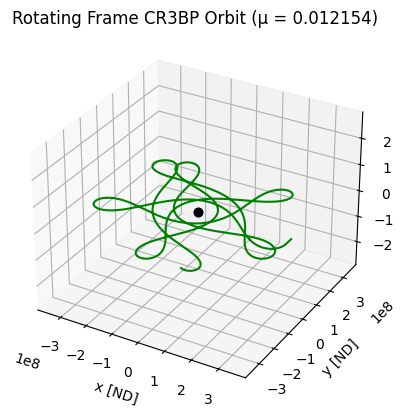

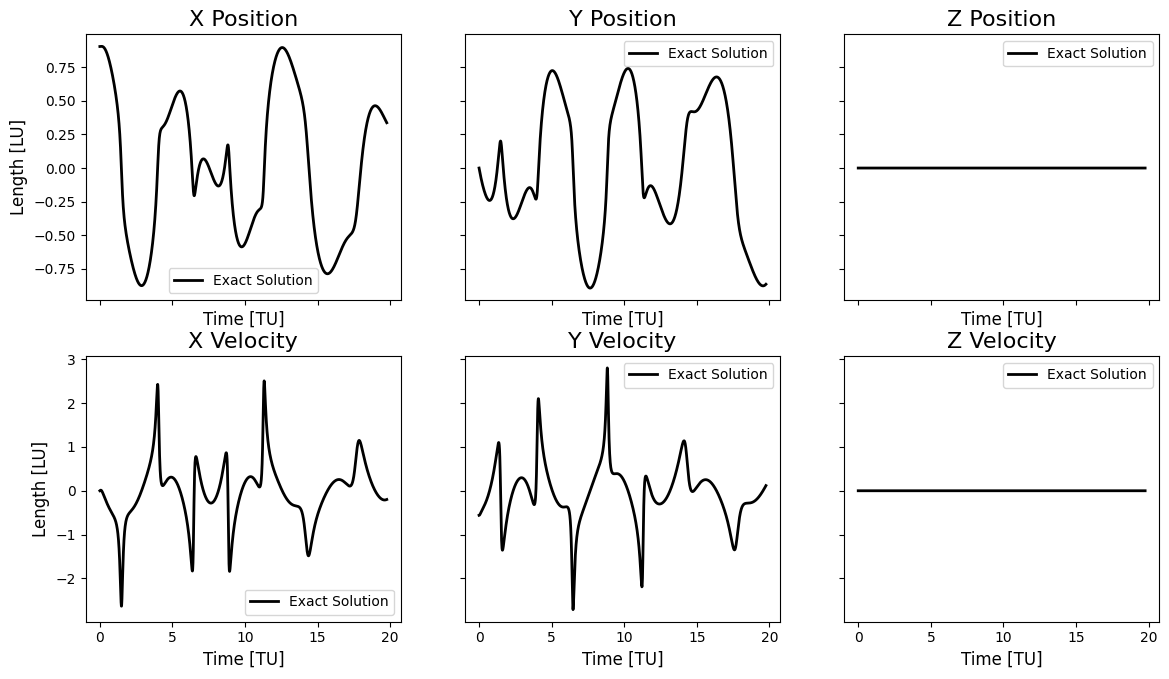

In [52]:
X = data_x.detach().numpy()
X = EM.conversion_vector*X

X_Sat = X[index,:,0]
Y_Sat = X[index,:,1]
Z_Sat = X[index,:,2]

m1_loc = [-mu, 0, 0]
m2_loc = [(1-mu), 0, 0]

# Rotating Frame Plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Adding Figure Title and Labels
ax.set_title('Rotating Frame CR3BP Orbit (\u03BC = ' + str(round(mu, 6)) + ')')
ax.set_xlabel('x [ND]')
ax.set_ylabel('y [ND]')
ax.set_zlabel('z [ND]')

# Plotting Rotating Frame Positions
ax.plot3D(X_Sat, Y_Sat, Z_Sat, c='green')
ax.plot3D(m1_loc[0], m1_loc[1], m1_loc[2], c='blue', marker='o')
ax.plot3D(m2_loc[0], m2_loc[1], m2_loc[2], c='black', marker='o')

# Setting Axis Limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3 / 4)

# Plotting states
fig, ax = plt.subplots(2, 3, sharex = 'col', sharey = 'row', figsize = (12, 7))
fig.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
titles = ['X Position', 'Y Position', 'Z Position', 'X Velocity', 'Y Velocity', 'Z Velocity']
plot_lines = []
for i in range(6):
    if i == 0:
        a = 0
        b = 0
    elif i == 1:
        a = 0
        b = 1
    elif i == 2:
        a = 0
        b = 2
    elif i == 3:
        a = 1
        b = 0
    elif i == 4:
        a = 1
        b = 1
    elif i == 5:
        a = 1
        b = 2
    p1, = ax[a,b].plot(time[:1976], data_x[index,:,i], color=colours[0], linestyle=line[0], label='Exact Solution', linewidth=2)
    ax[a,b].set_title(titles[i], fontsize = 16)
    ax[a,b].set_xlabel("Time [TU]", fontsize = 12)
    ax[a,0].set_ylabel("Length [LU]", fontsize = 12)
    ax[a,b].legend(fontsize=10)

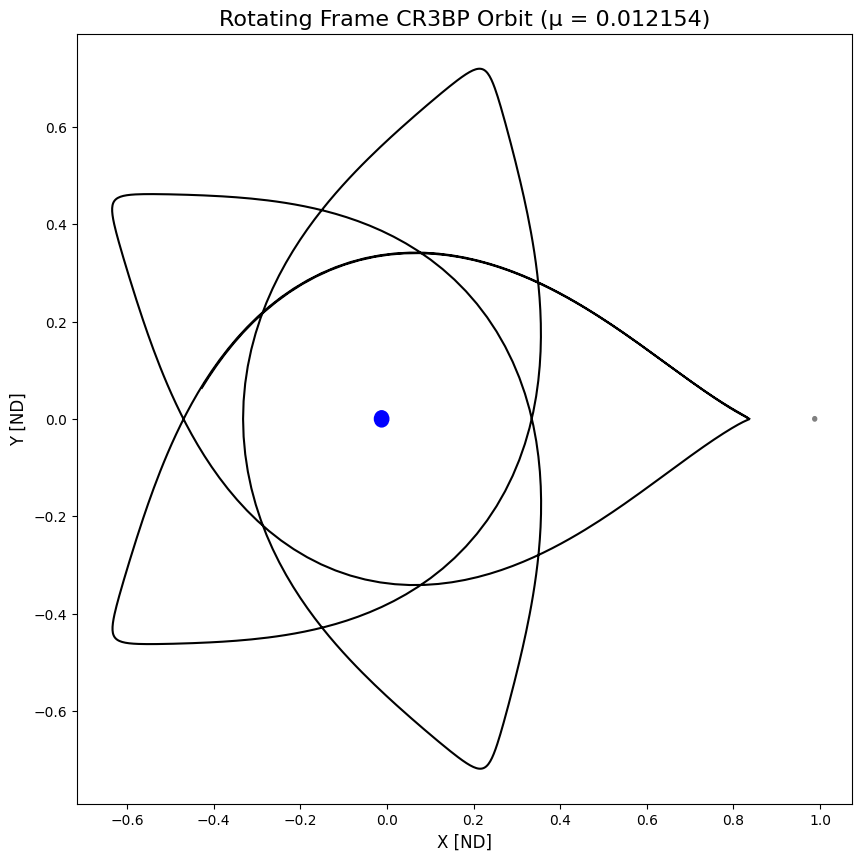

In [7]:
fig3 = plt.figure(figsize = (10, 10))
ax3 = plt.axes()

# Adding Figure Title and Labels
ax3.set_title('Rotating Frame CR3BP Orbit (\u03BC = ' + str(round(mu, 6)) + ')', fontsize=16)
ax3.set_xlabel('X [ND]', fontsize=12)
ax3.set_ylabel('Y [ND]', fontsize=12)


# Plotting Rotating Frame Positions
ax3.plot(X_Sat, Y_Sat, c='black')
Earth = patches.Circle((m1_loc[0], m1_loc[1]), 6370/Lstar, color='blue')
Moon = patches.Circle((m2_loc[0], m2_loc[1]), 1740/Lstar, color='grey')

ax3.add_patch(Earth)
ax3.add_patch(Moon)

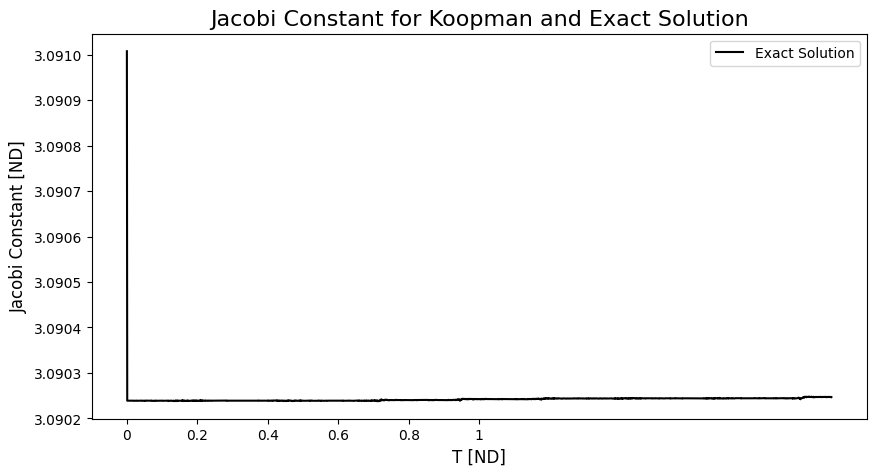

In [6]:
def Jacobi3(states,mu):
    x = states[:,0]
    y = states[:,1]
    z = states[:,2]
    xdot = states[:,3]
    ydot = states[:,4]
    zdot = states[:,5]

    mu1 = 1-mu
    mu2 = mu
    r1 = np.sqrt((x+mu2)**2 + y**2 + z**2)
    r2 = np.sqrt((x-mu1)**2 + y**2 + z**2)
 
    return (x**2 + y**2) + 2*(mu1/r1 + mu2/r2) - xdot**2 - ydot**2 - zdot**2

true = Jacobi3(X,mu)
fig5 = plt.figure(figsize = (10, 5))
ax5 = plt.axes()

# Adding Figure Title and Labels
ax5.set_title('Jacobi Constant for Koopman and Exact Solution', fontsize=16)
ax5.set_xlabel('T [ND]', fontsize=12)
ax5.set_ylabel('Jacobi Constant [ND]', fontsize=12)
ax5.set_xticks([0, 200, 400, 600, 800, 1000],[0, 0.20, 0.40, 0.60, 0.80, 1])

# Plotting Rotating Frame Positions
ax5.plot(true, c='black')
ax5.legend(labels=['Exact Solution', 'Koopman Solution'])